### Загружаем библиотеки и данные, ограничиваем ресурсы

In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES']='1'
os.environ['CUDA_DEVICE_ORDER']="PCI_BUS_ID"

In [2]:
import pandas as pd
import numpy as np

In [43]:
col_dtypes = {
    'type': 'category',
    'priority': np.uint16,
    'is_privatecategory': 'str',
    'class': int,
    'is_in_yandex': 'category',
    'is_return': 'category',  
}

In [70]:
train_df = pd.read_csv('../data/train_dataset_train_split.csv', dtype=col_dtypes)
train_df.priority = train_df.priority.astype(np.uint16)
train_df.mailtype = train_df.mailtype.astype(np.uint8)
train_df.mailctg = train_df.mailctg.astype(np.int8)
train_df.postmark = train_df.postmark.astype(np.uint16)
train_df.directctg = train_df.directctg.astype(np.uint8)
train_df.loc[train_df[train_df['is_privatecategory'] == '0'].index , 'is_privatecategory']= 'N'
train_df['class'] = train_df['class'].astype(np.uint8)

# категориальными называются те признаки, у которых уникальных признаков < 100
cat_features = [k for k in train_df.columns if train_df[k].unique().shape[0] < 100]
for key in cat_featuers:
    train_df[key] = train_df[key].astype('category')
cat_features

In [89]:
# убираем 'label' из списка категориальных признаков
cat_features_l = list(set(cat_features) - set(['label']))

In [90]:
# onehot encoding категориальных переменных
train_df_enc = pd.get_dummies(train_df, columns=cat_features_l)
train_df_enc.shape

(6000000, 164)

In [91]:
train_df_enc.sample(10)

,weight,transport_pay,weight_mfi,price_mfi,dist_qty_oper_login_1,total_qty_oper_login_1,total_qty_oper_login_0,total_qty_over_index_and_type,total_qty_over_index,label,...,type_ППС,type_СОПС,type_СЦ,type_ТИ,type_УКД,type_УМСЦ,type_Участок,type_Цех,is_wrong_rcpn_name_0,is_wrong_rcpn_name_1
2078354,175.0,24.15,158.0,300.0,23.0,201312.0,21792.0,223104.0,1349553.0,0,...,0,0,0,0,0,0,0,0,1,0
5138984,23.0,0.00,30.0,817.0,184.0,67541214.0,7870.0,67549084.0,72981134.0,0,...,0,0,0,0,0,0,0,1,1,0
22508,89.0,0.00,51.0,367.0,184.0,67541214.0,7870.0,67549084.0,72981134.0,0,...,0,0,0,0,0,0,0,1,1,0
4898304,254.0,0.00,0.0,0.0,153.0,26432806.0,6158583.0,32591389.0,58539804.0,0,...,0,0,0,0,0,0,0,1,0,1
3372263,54.0,0.00,82.0,335.0,13.0,19661.0,6558.0,26219.0,493439.0,1,...,0,0,0,0,0,0,0,0,1,0
5979054,83.0,0.00,86.0,200.0,184.0,67541214.0,7870.0,67549084.0,72981134.0,0,...,0,0,0,0,0,0,0,1,1,0
947512,265.0,29.22,25.0,98.0,106.0,17348074.0,3469387.0,20817461.0,20821109.0,0,...,0,0,0,1,0,0,0,0,1,0
1629734,341.0,0.00,330.0,770.0,914.0,48856658.0,83318932.0,132175590.0,136819803.0,0,...,0,0,0,0,0,0,0,0,1,0
949734,1432.0,82.12,60.0,113.0,28.0,1702354.0,16753.0,1719107.0,17871673.0,0,...,0,0,0,0,0,0,0,0,1,0
5103853,179.0,0.00,261.0,2.0,45.0,3084561.0,2706810.0,5791371.0,38194165.0,0,...,0,0,0,0,0,0,0,0,1,0


### Сохраняем датасеты. Дальше будем работать с ними

In [165]:
train_df.to_csv('../data/preprocessed_train.csv', index=False)
test_df.to_csv('../data/preprocessed_test.csv', index=False)

In [169]:
train_df_enc.to_csv('../data/preprocessed_train_encoded.csv', index=False)
test_df_enc.to_csv('../data/preprocessed_test_encoded.csv', index=False)

### Экспериментальная часть, не относящаяся к полученному в итоге решению

In [99]:
from sklearn.model_selection import train_test_split

seed = 481516
X_train, X_test = train_test_split(train_df_enc, test_size=.1, random_state=seed)

In [98]:
# resampling

In [100]:
from sklearn.utils import resample

In [102]:
x_good=X_train[X_train.label==0]
x_lost=X_train[X_train.label==1]

# upsample minority
lost_upsampled = resample(
    x_lost,
    replace=True, # sample with replacement
    n_samples=len(x_good)//10, # match number in majority class
    random_state=seed) # reproducible results

# combine majority and upsampled minority
X_upsampled = pd.concat([x_good, lost_upsampled])

# check new class counts
X_upsampled.label.value_counts()

0    5246148
1     524614
Name: label, dtype: int64

In [104]:
from sklearn.utils.class_weight import compute_class_weight
class_weight = compute_class_weight('balanced', classes=[0,1], y=X_upsampled.label)
class_weight

array([0.54999992, 5.50000762])

In [105]:
import xgboost as xgb

In [145]:
params = {
    'objective': 'binary:logistic',
#     'objective': 'binary:hinge',
    'gamma': 0.1,
    'max_depth': 5,
    'lambda': 3,
    'subsample': 0.7,
    'colsample_bytree': 0.7,
    'min_child_weight': 3,
    'silent': 1,
    'eta': 0.1,
    'seed': seed,
    'nthread': -1,
#     'tree_method': 'gpu_hist',
    'scale_pos_weight': class_weight[1],
#     'predictor': 'gpu_predictor',
}

num_round = 50

dtrain = xgb.DMatrix(X_upsampled.drop(columns='label'), label=X_upsampled.label)
dtest = xgb.DMatrix(X_test.drop(columns='label'), label=X_test.label)
watchlist = [(dtrain, 'train'), (dtest, 'test')]
bst = xgb.train(params, dtrain, num_round, watchlist)

y_pred_xgb = bst.predict(dtest)

/home/worker/.local/lib/python3.9/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


[08:55:29] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.

[0]	train-logloss:0.60691	test-logloss:0.60654
[1]	train-logloss:0.54826	test-logloss:0.54709
[2]	train-logloss:0.48826	test-logloss:0.48704
[3]	train-logloss:0.43796	test-logloss:0.43673
[4]	train-logloss:0.39519	test-logloss:0.39399
[5]	train-logloss:0.35919	test-logloss:0.35804
[6]	train-logloss:0.32804	test-logloss:0.32695
[7]	train-logloss:0.30103	test-logloss:0.30001
[8]	train-logloss:0.27746	test-logloss:0.27653
[9]	train-logloss:0.25746	test-logloss:0.25658
[10]	train-logloss:0.23942	test-logloss:0.23864
[11]	train-logloss:0.22618	test-logloss:0.22521
[12]	train-logloss:0.21218	test-logloss:0.21132
[13]	train-logloss:0.20179	test-logloss:0.20083
[14]	train-logloss:0.19078	test-logloss:0.18994
[15]	train-logloss:0.18053	test-logloss:0.17978
[16]	train-logloss:0.17145	test-logloss:0.17079
[17]	train-logloss:0.16360	test-logloss:0.16303
[18]	train-logloss:0.15782	test-logloss:0.15718
[19]	train-log

In [110]:
test_df = pd.read_csv('../data/test_dataset_test_split.csv', dtype=col_dtypes)
test_df.priority = test_df.priority.astype(np.uint16)
test_df.mailtype = test_df.mailtype.astype(np.uint8)
test_df.mailctg = test_df.mailctg.astype(np.int8)
test_df.postmark = test_df.postmark.astype(np.uint16)
test_df.directctg = test_df.directctg.astype(np.uint8)
test_df.loc[test_df[test_df['is_privatecategory'] == '0'].index , 'is_privatecategory']= 'N'
test_df['class'] = test_df['class'].astype(np.uint8)

for key in cat_features_l:
    test_df[key] = test_df[key].astype('category')
cat_features

['type',
 'priority',
 'is_privatecategory',
 'class',
 'is_in_yandex',
 'is_return',
 'mailtype',
 'mailctg',
 'directctg',
 'postmark',
 'is_wrong_sndr_name',
 'is_wrong_rcpn_name',
 'is_wrong_phone_number',
 'is_wrong_address',
 'label',
 'oper_type',
 'oper_attr']

In [123]:
whole_df = pd.concat([train_df.drop(columns='label'), test_df])
whole_df_enc = pd.get_dummies(whole_df, columns=cat_features_l)
test_df_enc = whole_df_enc.iloc[whole_df_enc.shape[0]-test_df.shape[0]:]
test_df_enc.shape

(4000000, 163)

In [147]:
sum(y_pred_xgb > .5)

42139

In [130]:
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, roc_auc_score

def compete_score(y_true, y_pred):
    return 0.1* recall_score(y_true, y_pred) + 0.9*roc_auc_score(y_true, y_pred)

In [149]:
compete_score(X_test.label, y_pred_xgb>.5)

0.9786188872313302

<AxesSubplot: >

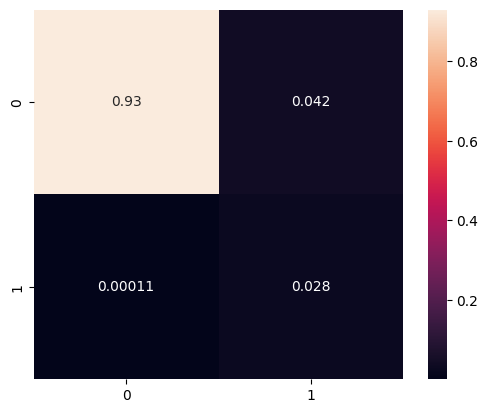

In [151]:
import seaborn as sns

sns.heatmap(confusion_matrix(X_test.label, y_pred_xgb>.5, normalize='all'), annot=True, square=True)

In [152]:
dinfer = xgb.DMatrix(test_df_enc)
infer_pred_xgb = bst.predict(dinfer)
# infer_pred_xgb.sum()

In [158]:
infer_df_idx = pd.read_csv('../data/test_dataset_test.csv')['id']

/tmp/ipykernel_2278628/1225005307.py:1: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  infer_df_idx = pd.read_csv('../data/test_dataset_test.csv')['id']


In [161]:
submission = pd.DataFrame({'id': infer_df_idx, 'label':(infer_pred_xgb>.5).astype(int)})
submission['label'].sum()

280642

In [170]:
dtypes = {col: train_df_enc[col].dtype.name for col in train_df_enc.columns}
dtypes

{'weight': 'float64',
 'transport_pay': 'float64',
 'weight_mfi': 'float64',
 'price_mfi': 'float64',
 'dist_qty_oper_login_1': 'float64',
 'total_qty_oper_login_1': 'float64',
 'total_qty_oper_login_0': 'float64',
 'total_qty_over_index_and_type': 'float64',
 'total_qty_over_index': 'float64',
 'label': 'category',
 'index_reg': 'int64',
 'index_loc': 'int64',
 'priority_0': 'uint8',
 'priority_7503': 'uint8',
 'priority_7504': 'uint8',
 'priority_7506': 'uint8',
 'mailctg_-1': 'uint8',
 'mailctg_0': 'uint8',
 'mailctg_1': 'uint8',
 'mailctg_3': 'uint8',
 'mailctg_5': 'uint8',
 'is_wrong_phone_number_0': 'uint8',
 'is_wrong_phone_number_1': 'uint8',
 'mailtype_0': 'uint8',
 'mailtype_1': 'uint8',
 'mailtype_2': 'uint8',
 'mailtype_4': 'uint8',
 'mailtype_5': 'uint8',
 'mailtype_6': 'uint8',
 'mailtype_7': 'uint8',
 'mailtype_8': 'uint8',
 'mailtype_9': 'uint8',
 'class_0': 'uint8',
 'class_1': 'uint8',
 'class_2': 'uint8',
 'class_3': 'uint8',
 'class_4': 'uint8',
 'class_5': 'uint8',

In [173]:
train_df_enc.sample(10000).corr()

/tmp/ipykernel_2278628/1746822673.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  train_df_enc.sample(10000).corr()


,weight,transport_pay,weight_mfi,price_mfi,dist_qty_oper_login_1,total_qty_oper_login_1,total_qty_oper_login_0,total_qty_over_index_and_type,total_qty_over_index,index_reg,...,type_ППС,type_СОПС,type_СЦ,type_ТИ,type_УКД,type_УМСЦ,type_Участок,type_Цех,is_wrong_rcpn_name_0,is_wrong_rcpn_name_1
weight,1.000000,0.767632,0.482346,0.143246,-0.071195,-0.064833,-0.049433,-0.061922,-0.047657,0.033306,...,0.009123,-0.014914,-0.006812,-0.007973,NaN,0.002524,0.016768,0.059274,-0.122264,0.122264
transport_pay,0.767632,1.000000,0.151992,-0.013912,-0.066834,-0.097943,-0.036579,-0.065466,-0.058760,0.047625,...,0.001286,-0.009352,-0.008723,0.014880,NaN,0.008714,0.043650,0.026815,-0.146881,0.146881
weight_mfi,0.482346,0.151992,1.000000,0.408349,-0.068131,-0.002313,-0.057461,-0.043259,-0.046019,0.001624,...,0.015563,-0.005068,-0.004507,0.020492,NaN,-0.004772,-0.003496,0.082709,0.105596,-0.105596
price_mfi,0.143246,-0.013912,0.408349,1.000000,-0.027721,0.024531,-0.034134,-0.015514,-0.013306,-0.006591,...,0.041737,-0.011221,-0.004438,-0.003185,NaN,-0.001549,-0.022246,0.060314,0.061462,-0.061462
dist_qty_oper_login_1,-0.071195,-0.066834,-0.068131,-0.027721,1.000000,0.685449,0.837686,0.886881,0.807802,-0.283101,...,-0.011090,-0.090792,-0.032733,-0.153000,NaN,-0.007804,-0.302122,-0.344275,0.037082,-0.037082
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
type_УМСЦ,0.002524,0.008714,-0.004772,-0.001549,-0.007804,-0.009628,-0.005481,-0.007825,-0.009439,-0.007169,...,-0.000141,-0.001139,-0.000491,-0.002289,NaN,1.000000,-0.004278,-0.007253,0.005977,-0.005977
type_Участок,0.016768,0.043650,-0.003496,-0.022246,-0.302122,-0.382149,-0.216413,-0.309744,-0.336570,0.187222,...,-0.006051,-0.048713,-0.020983,-0.097937,NaN,-0.004278,1.000000,-0.310270,-0.018732,0.018732
type_Цех,0.059274,0.026815,0.082709,0.060314,-0.344275,0.147581,-0.378031,-0.220598,-0.057194,-0.032148,...,-0.010258,-0.082585,-0.035574,-0.166038,NaN,-0.007253,-0.310270,1.000000,0.025921,-0.025921
is_wrong_rcpn_name_0,-0.122264,-0.146881,0.105596,0.061462,0.037082,0.093115,-0.037662,0.008850,0.003062,-0.067221,...,0.008453,-0.032949,-0.012452,0.004252,NaN,0.005977,-0.018732,0.025921,1.000000,-1.000000


In [171]:
'a'

'a'

In [164]:
submission.to_csv(f'../solutions/last-day-xgb-{compete_score(X_test.label, y_pred_xgb>.5)}.csv', index=False)

In [163]:
submission

,id,label
0,7815282,0
1,8443555,0
2,6352559,0
3,4921420,0
4,1420440,0
...,...,...
3999995,9030800,0
3999996,6275048,0
3999997,4701757,0
3999998,611153,0


In [128]:
infer_pred_xgb

array([0., 0., 0., ..., 0., 0., 0.], dtype=float32)

In [137]:
def baselineNN(dims):
    model = Sequential()
    model.add(Dense(10, input_dim=dims, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))
    sgd = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
    #model.compile(loss='binary_crossentropy', optimizer=sgd, metrics=['accuracy'])
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

def use_keras_nn_model(x, y, xx, yy, epochs):
    model = baselineNN(x.shape[1])
    model.fit(x.as_matrix(), y.as_matrix(), epochs=epochs)
    y_pred = model.predict(xx.as_matrix()).reshape(xx.shape[0],)
    return y_pred, model

In [ ]:
y_pred_nn, model_nn = use_keras_nn_model(
    x_train.drop(columns='label'), 
    y_train.label,
    X_test.drop(columns='label'), 
    y_test.label, 
    100
)

In [174]:
drops = [key for key in X_upsampled.columns if 'oper' in key]

['dist_qty_oper_login_1',
 'total_qty_oper_login_1',
 'total_qty_oper_login_0',
 'oper_type_0',
 'oper_type_1',
 'oper_type_2',
 'oper_type_3',
 'oper_type_4',
 'oper_type_5',
 'oper_type_6',
 'oper_type_8',
 'oper_type_9',
 'oper_type_10',
 'oper_type_11',
 'oper_type_12',
 'oper_type_14',
 'oper_type_15',
 'oper_type_20',
 'oper_type_24',
 'oper_type_26',
 'oper_type_29',
 'oper_type_30',
 'oper_type_34',
 'oper_type_39',
 'oper_type_41',
 'oper_type_104',
 'oper_type_114',
 'oper_type_128',
 'oper_type_131',
 'oper_type_154',
 'oper_type_183',
 'oper_type_184',
 'oper_type_185',
 'oper_type_192',
 'oper_type_1001',
 'oper_type_1002',
 'oper_type_1003',
 'oper_type_1004',
 'oper_type_1005',
 'oper_type_1009',
 'oper_type_1012',
 'oper_type_1013',
 'oper_type_1014',
 'oper_type_1015',
 'oper_type_1016',
 'oper_type_1017',
 'oper_type_1018',
 'oper_type_1019',
 'oper_type_1020',
 'oper_type_1021',
 'oper_type_1022',
 'oper_type_1023',
 'oper_type_1025',
 'oper_type_1026',
 'oper_type_1

In [210]:
params = {
    'objective': 'binary:logistic',
#     'objective': 'binary:hinge',
    'gamma': 0.1,
    'max_depth': 5,
    'lambda': 3,
    'subsample': 0.7,
    'colsample_bytree': 0.7,
    'min_child_weight': 3,
    'silent': 1,
    'eta': 0.5,
    'seed': seed,
    'nthread': -1,
#     'tree_method': 'gpu_hist',
    'scale_pos_weight': class_weight[1],
#     'predictor': 'gpu_predictor',
}

num_round = 100

dtrain = xgb.DMatrix(X_upsampled.drop(columns=['label',]+drops), label=X_upsampled.label)
dtest = xgb.DMatrix(X_test.drop(columns=['label', ] + drops), label=X_test.label)
watchlist = [(dtrain, 'train'), (dtest, 'test')]
bst = xgb.train(params, dtrain, num_round, watchlist)

y_pred_xgb = bst.predict(dtest)

/home/worker/.local/lib/python3.9/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


[14:29:48] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.

[0]	train-logloss:0.44565	test-logloss:0.43996
[1]	train-logloss:0.36825	test-logloss:0.35993
[2]	train-logloss:0.32620	test-logloss:0.31717
[3]	train-logloss:0.30492	test-logloss:0.29561
[4]	train-logloss:0.29325	test-logloss:0.28341
[5]	train-logloss:0.28579	test-logloss:0.27564
[6]	train-logloss:0.28137	test-logloss:0.27119
[7]	train-logloss:0.27834	test-logloss:0.26836
[8]	train-logloss:0.27642	test-logloss:0.26664
[9]	train-logloss:0.27442	test-logloss:0.26462
[10]	train-logloss:0.27309	test-logloss:0.26330
[11]	train-logloss:0.27255	test-logloss:0.26275
[12]	train-logloss:0.26234	test-logloss:0.25274
[13]	train-logloss:0.26044	test-logloss:0.25083
[14]	train-logloss:0.26033	test-logloss:0.25078
[15]	train-logloss:0.26002	test-logloss:0.25052
[16]	train-logloss:0.25739	test-logloss:0.24782
[17]	train-logloss:0.25732	test-logloss:0.24778
[18]	train-logloss:0.25728	test-logloss:0.24777
[19]	train-log

In [197]:
dinfer = xgb.DMatrix(test_df_enc.drop(columns=drops))
infer_pred_xgb = bst.predict(dinfer)
# (infer_pred_xgb>.2).sum()

In [201]:
bscore = 0
bthr = 0
for thr in np.arange(0.1,1.0,0.1):
    score = compete_score(X_test.label, y_pred_xgb>thr)
    if score > bscore:
        bscore=score
        bthr=thr
        
score, bthr

(0.5451925894576087, 0.4)

In [200]:
y_pred_xgb>thr

array([False, False, False, ..., False, False, False])

In [ ]:
bscore = 0
bthr = 0
for thr in np.linspace(0.1,1.0,0.1):
    score = compete_score(X_test.label, y_pred_xgb>thr)
    if score > bscore:
        score=bscore
        bthr=thr
        
score, bthr

In [185]:
(infer_pred_xgb>.4).sum()

959485

In [186]:
(infer_pred_xgb>.45)

array([ True,  True,  True, ..., False, False,  True])

In [194]:
submission = pd.DataFrame({'id': infer_df_idx, 'label':(infer_pred_xgb>.3).astype(int)})
submission['label'].sum()

995279

In [193]:
compete_score(X_test.label, y_pred_xgb>.3)

0.876926975727381

In [195]:
submission.to_csv(f'../solutions/last-day-xgb-{compete_score(X_test.label, y_pred_xgb>.3)}.3.csv', index=False)